In [1]:
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
#### Preprocecing ###

In [3]:
Confirmed = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv")

In [4]:
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
confirmed = df

In [5]:
contries = confirmed.max() >= 1000
confirmed = confirmed.loc[:, contries]

In [6]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
recovered = df.loc[:, contries]

In [7]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
death = df.loc[:, contries]

In [8]:
removed = recovered + death

In [9]:
### Data Preparation ###

In [10]:
S = confirmed.values
R = removed.values
L = 7

In [11]:
data = {'T': S.shape[0], 'N': S.shape[1], 'L':L, 'S': S, 'R': R}

In [12]:
### Model ###

In [116]:
sm = pystan.StanModel(file="covid19.stan")

In [ ]:
# Train the model and generate samples
fit = sm.sampling(data=data, iter=1000, chains=4)

In [15]:
### Simulation and Visualization functions ###

In [16]:
T = S.shape[0]
N = S.shape[1]

In [110]:
def simulate(a, p, c, sigma_S, sigma_R, start, horizen):
    cumulative = confirmed.loc[start + pd.Timedelta(days=L)].values
    recovered = removed.loc[start + pd.Timedelta(days=L)].values
    infected_list = [confirmed.loc[d].values - removed.loc[d].values for d 
                     in pd.date_range(start, periods=L, freq='D')]
    for d in range(L, horizen):
        cumulative0 = cumulative
        r = infected_list[-L] @ c[L-1]
        for k in range(1, L-1):
            r = r + (infected_list[-k] - infected_list[-k-1]) @ c[k-1]
        print(r)
        I = r * (1 - cumulative / p) + np.sqrt(sigma_S) * np.random.randn(N)
        cumulative = cumulative + np.maximum(I, 0)
        recovered = recovered + a * (cumulative0 - recovered) + np.sqrt(sigma_R) * np.random.randn(N)
        recovered = np.maximum(recovered, 0)
        infected = np.maximum(cumulative - recovered, 0)
        infected_list.append(infected)
    infected = pd.DataFrame(infected_list, 
                            columns=confirmed.columns,
                            index=pd.date_range(start, periods=horizen, freq='D'))
    return infected

In [111]:
def draw_infected(fit, start, horizen, country):
    a = fit['a']
    p = fit['p']
    c = fit['c']
    sigma_S = fit['sigma_S']
    sigma_R = fit['sigma_R']
    np.random.shuffle(a)
    np.random.shuffle(p)
    np.random.shuffle(c)
    np.random.shuffle(sigma_S)
    np.random.shuffle(sigma_R)
    data_list =[]
    for i in range(10):
        infected = simulate(a[i], p[i], c[i], sigma_S[i], sigma_R[i], start, horizen)
        data = pd.DataFrame({"infected":infected[country]})
        data['date'] = pd.date_range('2020-01-22', periods=horizen, freq='D')
        data_list.append(data)
    data = pd.concat(data_list)
    data['simulated'] = True
    data_real = pd.DataFrame({'infected':(confirmed - removed)[country]})
    data_real['simulated'] = False
    data = pd.concat([data, data_real])
    data['date'] = data.index
    data['days'] = (data['date'] - pd.to_datetime('2020-01-22')).apply(lambda x: x.days)
    sns.relplot(x="days", y="infected", hue="simulated", kind="line", ci='sd', data=data);

In [112]:
### Validation ###

[ 408.81238127  668.84460564 5452.80223757  716.70357009  883.81911395
  839.34055636  102.22924835  650.99710198  332.51094358  936.16085031
  382.38257598  670.79445744  663.73479344  545.1633247   841.958927
  848.10404858]
[ 2757.24936062  1956.94181205 96109.64620962  5892.56070516
  3544.77409768  4669.7078243   1826.7873438   6433.36062739
 17698.89703175  3079.31946087  2304.52910992  3105.58911247
  3954.26308451  5846.95372586  2020.36363539  3789.42033687]
[ 11373.50313891  21630.83617702 506007.01046228  20837.860599
  17890.6119506   18360.83769358  10066.45734894  23485.56211453
  42046.67475074  14420.18551302  11929.09830516  12207.03536054
  24841.96742432  16426.71076704  13686.64805573  13860.90815239]
[ 955.01381197 1206.24662324 7309.10411885 1030.58084893  507.00060332
  817.74625966 1095.50221141  672.98085789  719.53895576 1027.2462002
 1010.08116703  657.97862791  993.63172351  537.33152093  724.15854253
  746.24514568]
[  4291.74737246   5209.01946645 198885.8

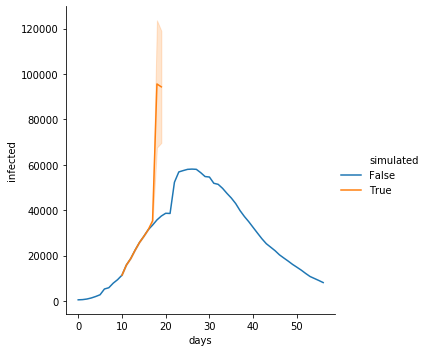

In [113]:
draw_infected(fit, pd.to_datetime('2020-02-01'), 10, 'China')

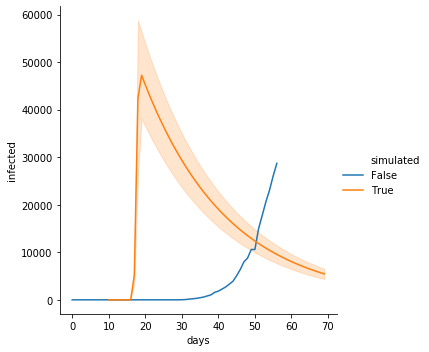

In [21]:
draw_infected(fit, pd.to_datetime('2020-02-01'), 60, 'Italy')

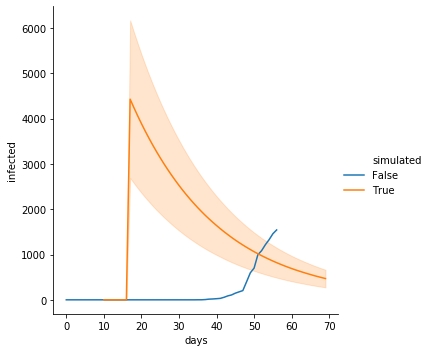

In [22]:
draw_infected(fit, pd.to_datetime('2020-02-01'), 60, 'Norway')

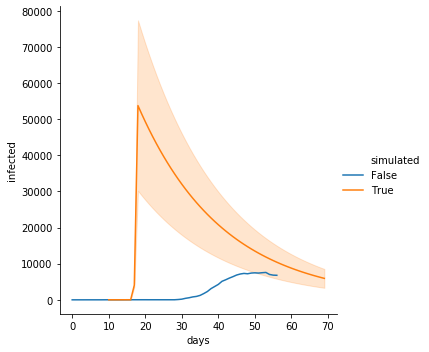

In [23]:
draw_infected(fit, pd.to_datetime('2020-02-01'), 60, 'Korea, South')

In [24]:
### Prediction ###

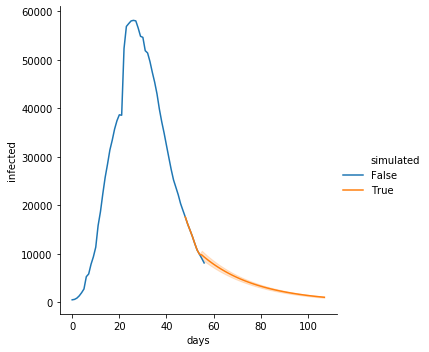

In [25]:
draw_infected(fit, pd.to_datetime('2020-03-10'), 60, 'China')

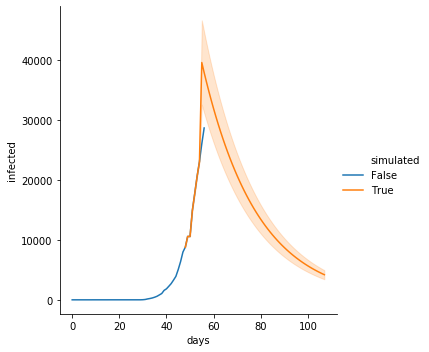

In [26]:
draw_infected(fit, pd.to_datetime('2020-03-10'), 60, 'Italy')

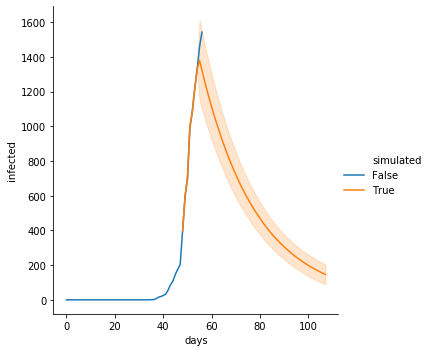

In [27]:
draw_infected(fit, pd.to_datetime('2020-03-10'), 60, 'Norway')

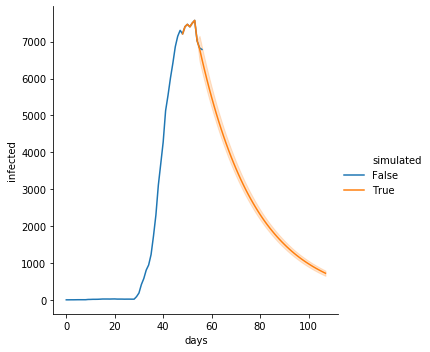

In [28]:
draw_infected(fit, pd.to_datetime('2020-03-10'), 60, 'Korea, South')

In [34]:
fit['c'].shape

(2000, 7, 16, 16)

In [61]:
fit['c'][1][4][2]

array([0.07916612, 0.00217008, 0.17732242, 0.06295196, 0.12221689,
       0.06176771, 0.0076818 , 0.02411804, 0.02727769, 0.05460622,
       0.00403423, 0.03420031, 0.00563954, 0.10492716, 0.04124816,
       0.00573769])

In [43]:
list(range(7, 1))

[]

In [55]:
confirmed

Country/Region,Austria,Belgium,China,Denmark,France,Germany,Iran,Italy,"Korea, South",Netherlands,Norway,Spain,Sweden,Switzerland,US,United Kingdom
2020-01-22,0,0,548,0,0,0,0,0,1,0,0,0,0,0,1,0
2020-01-23,0,0,643,0,0,0,0,0,1,0,0,0,0,0,1,0
2020-01-24,0,0,920,0,2,0,0,0,2,0,0,0,0,0,2,0
2020-01-25,0,0,1406,0,3,0,0,0,2,0,0,0,0,0,2,0
2020-01-26,0,0,2075,0,3,0,0,0,3,0,0,0,0,0,5,0
2020-01-27,0,0,2877,0,3,1,0,0,4,0,0,0,0,0,5,0
2020-01-28,0,0,5509,0,4,4,0,0,4,0,0,0,0,0,5,0
2020-01-29,0,0,6087,0,5,4,0,0,4,0,0,0,0,0,5,0
2020-01-30,0,0,8141,0,5,4,0,0,4,0,0,0,0,0,5,0
2020-01-31,0,0,9802,0,5,5,0,2,11,0,0,0,1,0,7,2


In [62]:
list(range(1, L-1))

[1, 2, 3, 4, 5]